In [3]:
"""
2601547:
In my model there are stochastic elements to the input population densities. 
However to see purely the effects of the parameter changes in the simulation, I randomly generate an arry for P and Z and then carry that forward

"""
import numpy as np

Fixed_P0 = np.array([
    [439.12943495, 444.20882342, 431.03553393, 366.85117631],
    [376.72498478, 449.4337851 , 482.00309735, 467.83362289],
    [441.51394676, 409.21991034, 367.39580638, 353.46273781],
    [445.40582853, 365.13579475, 498.54824327, 446.61794597],
    [362.74833836, 444.92223723, 409.986805  , 439.46576213],
    [397.13744586, 460.71923475, 371.63701472, 435.4831223 ]
])
Fixed_Z0 = np.array([
    [122.90636694, 120.49896742,  64.92967535,  99.7156875 ],
    [113.49260769, 101.12827783, 120.97835232,  57.77477193],
    [123.51895534,  74.9017687 , 125.47016959, 112.69255729],
    [ 73.19590613, 122.60666607,  91.96888483, 117.60917745],
    [ 51.88981195,  68.03260366,  57.36821238, 135.62704724],
    [ 53.61411518,  97.50450797, 116.97050314, 110.84950078]
])

[[439.12943495 444.20882342 431.03553393 366.85117631]
 [376.72498478 449.4337851  482.00309735 467.83362289]
 [441.51394676 409.21991034 367.39580638 353.46273781]
 [445.40582853 365.13579475 498.54824327 446.61794597]
 [362.74833836 444.92223723 409.986805   439.46576213]
 [397.13744586 460.71923475 371.63701472 435.4831223 ]]
[[122.90636694 120.49896742  64.92967535  99.7156875 ]
 [113.49260769 101.12827783 120.97835232  57.77477193]
 [123.51895534  74.9017687  125.47016959 112.69255729]
 [ 73.19590613 122.60666607  91.96888483 117.60917745]
 [ 51.88981195  68.03260366  57.36821238 135.62704724]
 [ 53.61411518  97.50450797 116.97050314 110.84950078]]
Equiilibrium Prey Value = 400
Equiilibrium Prey Value = 100
Equiilibrium Prey / Predator Ratio = 4.0x
Timestep: 0.00002s
Timestep 100000: P min=186.1601, P max=404.5368, Z min=9.3165, Z max=276.7216
Timestep 200000: P min=219.6851, P max=483.4191, Z min=3.4931, Z max=240.2647
Timestep 300000: P min=283.6560, P max=549.7745, Z min=3.9256

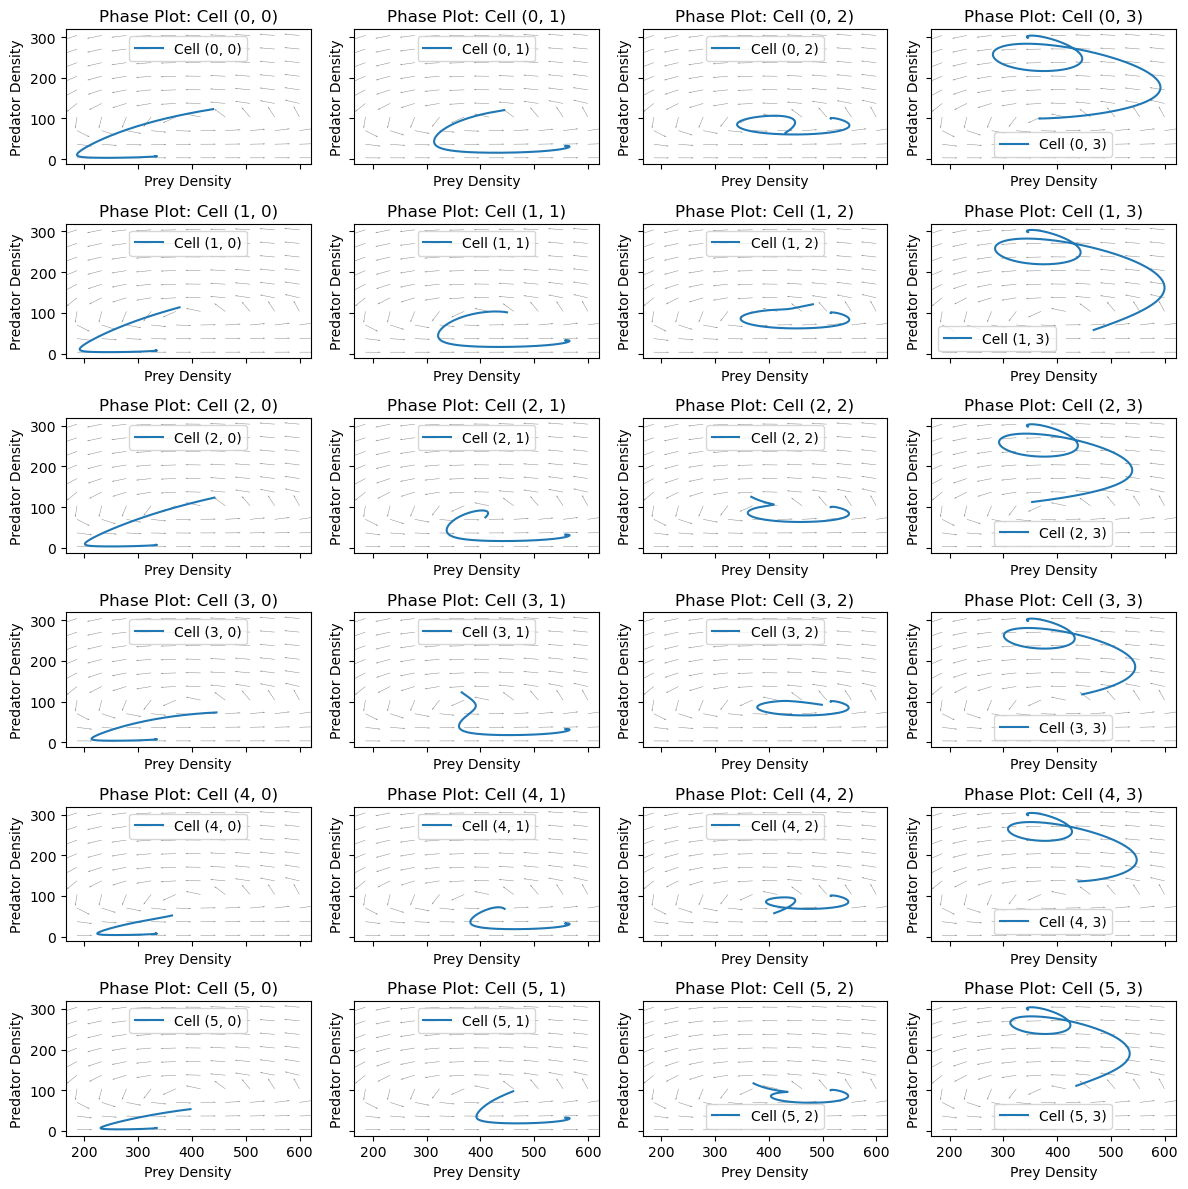

In [5]:
"""
2601547: 

Note, my comments have been labelled as 2601547 as there were some comments in code from the practicals and I wanted to keep them as 
they are helpful in explaining. Anything not labelled explicitly 2601547 is a comment from the previous author of that lab code

"""

##################################################################################################################################################################################################################
#                                                                                                IMPORT LIBRARIES                                                                                                #
##################################################################################################################################################################################################################

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time

##################################################################################################################################################################################################################
#                                                                                                INPUT PARAMETERS                                                                                                #
##################################################################################################################################################################################################################

"""
2601547: 

This is my parameter dictionary and is essentially a control panel for ease of use with the model. Any changess are made here

The starting values are based on 4.3 of 'GEOGM0058 Practical 4' which I used to initally caliberate / verify the results

"""

parameters = {
    # 2601547: Model settings:
    'alpha': 1.00, # 2601547: From 4.3, practical 4
    'beta': 0.01, # 2601547: From 4.3, practical 4
    'gamma': 1.00, # 2601547: From 4.3, practical 4
    'delta': 0.25, # 2601547: From 4.3, practical 4
    'K': 1e6, # 2601547: High as I include functionality for carrying capacity, but do not want it to influence actual dynamics for my specific simulation
    'current_velocity': 3.00, # 2601547: SIM 1 initial current value
    'diffusion': 2.50, # 2601547: SIM 1 initial current value
    
    'PERT_P': 100, # 2601547: Peturb to Prey (value from 4.3, practical 4)
    'PERT_Z': 50, # 2601547: Peturb to Predator
    # 2601547: Grid settings:
    'nx': 4,
    'nz': 6,
    # 2601547: Simulation / environment settings:
    'timesteps': 1000000,
    'domain_size': (10, 10), # physical size of area which effects flux calcs
    'dt_manual': 0.00002
}

##################################################################################################################################################################################################################
#                                                                                             TIMESTEP DETERMINATION                                                                                             #
##################################################################################################################################################################################################################

def stable_time_step(vx, Dx, Dz, dx, dz):
    """
    2601547: 
    
    This is code / function taken directly from "pollution.py" (GEOGM0058 Practical 7) with one ammendment made i.e. 
    return dt -> return min(dt, dt_manual), which essentially just outputs 0.002 (or whatever the parameter is set to), which adds 
    some stability for the timesteps. This value is taken from the 'GEOGM0058 Practical 4: Lotka-Volterra Predator Prey' file, 
    specifically 4.3 with the "lv_pp_model" model which I used to initally calibrate this model It was 0.02, however I decreased 
    by an order of magnitude 1 as the model was not accurately capturing the dynamics of the system. Otherwise the functions show 
    a lot of instability as the calculted dt term is too large to capture the predator-prey dynamics, rather than just the 
    advection-diffusion dynamics

    Functionality is here to use this function, but in my simulation I essentially bypass atnd just set to my parameter value for
    stability purposes
    
    """
    dt_manual = parameters['dt_manual']
    dx2, dz2 = dx*dx, dz*dz
    dt_diff = dx2 * dz2 / (2 * (np.max(Dx)+np.max(Dz)) * (dx2 + dz2 ) + 1.0e-10) # stable time step. 
    dt_cfl = dx / (np.max(vx) + 1.0e-10) # advection stable step
    dt = min(dt_cfl, dt_diff)*0.5

    return dt_manual

##################################################################################################################################################################################################################
#                                                                                           ADVECTION / DIFFUSION MODEL                                                                                          #
##################################################################################################################################################################################################################

def euler_advection_diffusion_timestep(c0, vx, Dx, Dz, src, dt, dx, dz, upwind=True):
    """ 
    2601547: 
    
    This is code / function again taken from "pollution.py" (GEOGM0058 Practical 7), with some ammedments made around the way c is 
    updated acoss the grid. The model this function is taken from was designed to simulate pollutants in the air, looking at almost 
    a cross-sectional view of the earth as a grid i.e. ground as the bottom row cells and the atmosphere as the top. My approach 
    leverages the code, but instead I immagine looking top-down at a body of water as if e.g. from a satellite. In the former approach, 
    c values, which represent the concentration of pollution in a cell and hence determine the diffusion coefficients (these are 
    calculated by comparison of concentrations in neighbouring cells, more information in the lab file 'GEOGM0058 Practical 7: 
    Atmospheric pollution dispersal as an example of advection and diffusion processes') are updated depending on their position too. 
    For example, the bottom row of cells which represented the "ground boundary" would replicate c values in the row above, so that
    concentrations would be the same and hence the flux / diffusion coefficient between the two would be 0. This makes sense in that 
    context, as it prevents depoisiton (as intended). Similarly, at the top layer which represented the atmosphere, depending on a term 
    called "inversion", the values of c in the top row could be set to 0 (inversion=FALSE) essentially acting as a sink, or could
    use a similar approach to the ground boundary. In this regard, only the central cells actually had c / concentration values which
    updated depending on diffusion etc.

    My changes to the code therefore are limited - I keep all the diffusive elements, but remove any reference to inversion as this
    dynamic is not relevant for a top-down view of a body of water. I update the code so that all grid cells update their c values
    dependant on diffusive / advection dynamics only, and no values are set to 0 which would create an artificial sink etc. I finally
    add a condition that c cannot be negative, as this prevents any non-sensical cases


    ++++++++++++++++++++++++++ Comments from creator below ++++++++++++++++++++++++++

    
    Evolve the advection diffusion equation for pollution concentration 
    by one time step. Spatial discretization using the finite volume method
    on a rectangular mesh of rectangular cells. Forward Euler timestep
     
    Advection is limited to wind parallel to the x-axis
    
    Note the time-step and advection schemes here are for illustration. Real
    codes use better schemes (usually :)
    
    parameters
    ----------
    c0 ((nz, nx) ndarray) : cell-centered concentration at the start of the time step
    vx ((nz, nx+1) ndarray) : horizontal wind velocity at x-faces
    Dx ((nz, nx+1) ndarray) : horizontal diffusion coeffcient at x-faces
    Dz ((nz+1, nx) ndarray) : horizontal diffusion coeffcient at z-faces
    src: concentration source per unit time
    dt (float) : timestep. not checked for stability
    
    inversion: affects the boundary condition at the top boundary: 
               when true, pollution cannot cross the inversion.
               when false, concentration set to 0 at the top
    
    upwind: choice of advection schemne. When true, first-order upwind.
    when false, central difference
    
    returns
    ------
    c (ndarray): updated concentration
    
    """
    nz, nx = c0.shape
    c = c0.copy()
    
    #storage for face-centered fluxes. index j correspomnd to 'w' face of cell j
    Fx = np.zeros((nz, nx + 1))
    Fz = np.zeros((nz +1 , nx))
    
    #Diffusive fluxes (per unit volume) 
    Fx[:, 1:nx] = - Dx[:, 1:nx] * (c[:,1:nx] - c[:,0:nx-1]) / (dx*dx)
    Fz[1:nz, :] = - Dz[1:nz, :] * (c[1:nz,:] - c[0:nz-1,:]) / (dz*dz)
    
    #Advective fluxes
    if upwind:
       Fx[:, 1:nx] += np.where(vx[:,1:nx] > 0, vx[:,1:nx] * c[:,0:nx-1], -vx[:,1:nx]*c[:,1:nx]) / dx     
    else:
       Fx[:, 1:nx] += vx[:,1:nx] * (c[:,0:nx-1] + c[:,1:nx]) * 0.5 / dx
    
    # 2601547: Here I have made changes to the way c updates the array, by updating the grid cells which are updated from internal to all. Edges act like walls, system is closed.                  
    c[0:nz, 0:nx] += dt * (
        -(Fx[0:nz, 1:nx+1] - Fx[0:nz, 0:nx])
        -(Fz[1:nz+1, 0:nx] - Fz[0:nz, 0:nx])
        + src[0:nz, 0:nx] )

    # 2601547: I removed all boundary conditions as they are not 
    c = np.maximum(c, 0) # 2601547: I prevent negative values of c
    
    return c

##################################################################################################################################################################################################################
#                                                                                         DOMAIN / GRID SIZE DETERMINATION                                                                                       #
##################################################################################################################################################################################################################

def create_grid(P0, Z0, domain_size, parameters):
    """
    2601547: 
    
    This is code extracted from the the 'transport_pollution' function in "pollution.py" (GEOGM0058 Practical 7). I do not use 
    the funtion, however to to create a grid to run the simulations, I needed this section. The same grid used for advection-
    diffusion / atmospheric pollution is used, with the size dependant on the initial conditions for prey, and with a check that
    is the same size of the predator's 

    I have written out the paramters in the same style as the example code:

    parameters
    ----------
    P0 (ndarray) : initial prey density array
    Z0 (ndarray) : initial predator density array
    domain_size (tuple) : physical size of the spatial domain (x, z)
    vx ((nz, nx+1) ndarray) : horizontal current velocity at x-faces
    Dx ((nz, nx+1) ndarray) : horizontal diffusion coeffcient at x-faces
    Dz ((nz+1, nx) ndarray) : horizontal diffusion coeffcient at z-faces
    dt (float) : timestep
    
    """
    current_velocity, diffusion = parameters['current_velocity'], parameters['diffusion']
    
    # 2601547: Here I added a check that both P0 and Z0 are the same shape array. This is a safeguard that was requested by Dr Cornfold when discussing this code
    if P0.shape != Z0.shape:
        raise ValueError(f"P0 and Z0 must have the same shape. Got P0.shape={P0.shape}, Z0.shape={Z0.shape}")

    # 2601547: The grid is constructed here. I use a similar approach to the ap/d lab (see pollution.py, line 47) i.e. the grid size is determined by the initial conditions for prey
    nz, nx = P0.shape 
    # 2601547: Cell dimensions is also determined by my spatial domain size (see pollution.py, line 123)
    dx = domain_size[0] / nx 
    dz = domain_size[1] / nz

    # 2601547: Current speed / advection at cell x - faces (see pollution.py, line 137)
    vx = np.zeros((nz, nx + 1)) + current_velocity
    # 2601547: Diffusion at cell x-faces (see pollution.py, line 139)
    Dx = np.full((nz, nx + 1), diffusion)
    # 2601547: Diffusion at cell z-faces (see pollution.py, line 141)
    Dz = np.full((nz + 1, nx), diffusion)

    dt = stable_time_step(vx, Dx, Dz, dx, dz)
    print(f"Timestep: {dt:.5f}s") # 2601547: Minor ammendment to print statement

    return {'nz': nz, 'nx': nx, 'dx': dx, 'dz': dz, 'vx': vx, 'Dx': Dx, 'Dz': Dz, 'dt': dt, 'P': P0.copy(), 'Z': Z0.copy()}

##################################################################################################################################################################################################################
#                                                                                              LOTKA-VOLTERRA MODEL                                                                                              #
##################################################################################################################################################################################################################

def lotka_volterra_sources(P, Z, parameters):
    """
    2601547: 

    Based on GEOGM0058 Practical 7 part 4.3 and 4.4, functions 'lv_pp_model' and 'alt_pp_model' respectively, I have laid out
    the Lotka-Volterra Model I described in the paper i.e classical competitive with carry capacity. I used greek symbols in
    notation instead of "ABCD", as I thought it was more relevant in an academic writing context, so a parameter disctionary was
    used
    
    I have calculated the indvidual components that contribute to both prey and predator growth / death. In the advection-
    diffusion model, there is a source / sink "S" component. This is caculated as the growth - death i.e. a source if growth 
    exceeds death and a sink if the opposite is true. The src terms are calculated and returned so that they can be passed 
    through the advection-diffusion model in the next step of the simulation

    """
    alpha, beta, delta, gamma, K = parameters['alpha'], parameters['beta'], parameters['delta'], parameters['gamma'], parameters['K']

    prey_growth = alpha * P * (1.0 - P / K)
    prey_death = -beta * P * Z
    predator_growth = delta * beta * P * Z
    predator_death = -gamma * Z

    src_prey = prey_growth + prey_death
    src_pred = predator_growth + predator_death

    return src_prey, src_pred

##################################################################################################################################################################################################################
#                                                                                            ADVECTION-DIFFUSION MODEL                                                                                           #
##################################################################################################################################################################################################################

def predator_prey_advection_diffusion_step(P, Z, vx, Dx, Dz, parameters, dt, dx, dz):
    """
    2601547: 

    Here I pass through for each Prey and Predators values. As per the 'euler_advection_diffusion_timestep' function, I pass through 
    parameters where "P or "Z" are input as concentrtion i.e. "c0" and "src_prey" and "src_pred" as "src". In my current simulations,
    upwind is not used, so I have left it out

    This function is the crux of how the process works. Each simulation is seperated into two distinct steps which effect P and Z values
    for the next step:
    
    1) P and Z density / concentraion values are calculated in each iteration per cell based purely of the Lotka Volterra model i.e. 
    predation / competitve dynamics
    
    2) Then diffusion / advection is applied to that via the 'euler_advection_diffusion_timestep' function, resulting in P_updated and 
    Z_updated density values i.e. a new concentraion in each cell, caused due by spatial dynamics rather than because of predation / births
    / deaths, of spatial dynamics

    The new P_updated and Z_updated values are then used as P and Z respectuvely in the next iteration ensuring that both dynamics are
    captured

    """
    src_prey, src_pred = lotka_volterra_sources(P, Z, parameters)

    P_updated = euler_advection_diffusion_timestep(P, vx, Dx, Dz, src_prey, dt, dx, dz)
    Z_updated = euler_advection_diffusion_timestep(Z, vx, Dx, Dz, src_pred, dt, dx, dz)

    return P_updated, Z_updated

##################################################################################################################################################################################################################
#                                                                                  ADVECTION-DIFFUSION MODEL (AND INITIAL PLOT)                                                                                  #
##################################################################################################################################################################################################################

def run_simulation_v1():
    """
    2601547: 

    I fill out arrays P0 and Z0 i.e. initial conditions for P and Z densities with the equilibria conditions assuming spatial homogenuity 
    i.e. no advection / diffusion (plus a pertubing variable). These are akin to the starting conditions to the Lotka-Volterra model 
    described in 4.3, (specifically, "x_y_initial = (D/(C*B) + PERT_X , A/B)") except, I have a carrying capacity, so the solutions are 
    slightly different. This ensures, regardless of the starting coefficient / greek parameter values, the model will be in equilibrium, 
    if there is no advection or diffusion (i.e. they both equal 0). However, this is not true if there is any spatial elements, which is 
    the innovative aspect of this model, so it is somewhat trivial. It is, however, a good starting point, for identifying closed orbits, 
    even with spatial dynamics

    The first plot is, again, the very basic one from 4.3, which was helpful to begin thinking about presentation of results

    """
    global grid # 2601547: This allows me to use the grid value in other (i.e. the next plot).
    alpha, beta, delta, gamma, K, nx, nz = parameters['alpha'], parameters['beta'], parameters['delta'], parameters['gamma'], parameters['K'], parameters['nx'], parameters['nz']
    PERT_P, PERT_Z, timesteps, domain_size = parameters['PERT_P'], parameters['PERT_Z'], parameters['timesteps'], parameters['domain_size'] # 2601547: seperate line purely for my own readability
    P0 = Fixed_P0
    Z0 = Fixed_Z0
    print(P0)
    print(Z0)
    
    # 2601547: This allows me to see the actual equilbrium values depending on the input parameters. In this case, I just wanted to check they were the same as the lab
    eq_p = gamma / (delta * beta)
    eq_z = (alpha / beta) * (1 - (gamma / (delta * beta * K)))
    print(f"Equiilibrium Prey Value = {eq_p:.0f}")
    print(f"Equiilibrium Prey Value = {eq_z:.0f}")
    # 2601547: I calculated this as I may use it to link to empirical things in the paper i.e. ensuring that there is some realistic basis to the model
    print(f"Equiilibrium Prey / Predator Ratio = {eq_p / eq_z:.1f}x")
    
    # 2601547: This calls / runs the grid function for the simulation
    grid = create_grid(P0, Z0, domain_size, parameters)
    P = grid['P']
    Z = grid['Z']

    # 2601547: This stores the initial conditions
    P_history = np.zeros((timesteps, nz, nx))
    Z_history = np.zeros((timesteps, nz, nx))
    P_history[0, :, :] = P
    Z_history[0, :, :] = Z

    # 2601547: Starting from t=1, I use a For loop to run the simulation through the timesteps value. P_history and Z_history track the values over time, hence the 3D
    for t in range(1, timesteps):
        P, Z = predator_prey_advection_diffusion_step(
            P, Z, grid['vx'], grid['Dx'], grid['Dz'], parameters, grid['dt'], grid['dx'], grid['dz']
        )
        P_history[t, :, :] = P
        Z_history[t, :, :] = Z

        # 2601547: I used this function to get some data on what the evolution and variance of the populations look like at each timestep. It was helpful for debugging some issues too
        if t % (timesteps / 10) == 0:
            print(f"Timestep {t}: P min={np.min(P):.4f}, P max={np.max(P):.4f}, Z min={np.min(Z):.4f}, Z max={np.max(Z):.4f}")

    # 2601547: Phase Plot code taken and ammended from 4.3 in GEOGM0058 Practical 4
    # Modify the plotting section to add vector fields
    fig, axes = plt.subplots(nz, nx, figsize=(12, 12), sharex=True, sharey=True)
    
    # Create a grid of prey and predator densities for the vector field
    P_grid, Z_grid = np.meshgrid(
        np.linspace(np.min(P_history), np.max(P_history), 10), 
        np.linspace(np.min(Z_history), np.max(Z_history), 10)
    )
    
    # Compute the vector field for each point in the grid
    dP_dt = parameters['alpha'] * P_grid * (1 - P_grid / parameters['K']) - parameters['beta'] * P_grid * Z_grid
    dZ_dt = parameters['delta'] * parameters['beta'] * P_grid * Z_grid - parameters['gamma'] * Z_grid
    
    # Normalise the vector field to unit length
    magnitude = np.sqrt(dP_dt**2 + dZ_dt**2)
    dP_dt_normalised = dP_dt / (magnitude + 1e-10)  # Avoid division by zero
    dZ_dt_normalised = dZ_dt / (magnitude + 1e-10)
    
    for i in range(nz):
        for j in range(nx):
            ax = axes[i, j]
            
            # Plot the normalised vector field with consistent scaling
            ax.quiver(
                P_grid, Z_grid, dP_dt_normalised, dZ_dt_normalised,
                color="gray", alpha=0.9, scale=0.035, scale_units='xy', width=0.002, angles='xy'
            )
        
            # Plot the phase trajectory
            ax.plot(P_history[:, i, j], Z_history[:, i, j], label=f"Cell ({i}, {j})")
            
            ax.set_title(f"Phase Plot: Cell ({i}, {j})")
            ax.set_xlabel("Prey Density")
            ax.set_ylabel("Predator Density")
            ax.legend()

    plt.tight_layout()
    plt.show()




##################################################################################################################################################################################################################
#                                                                                                 RUN SIMULATION                                                                                                 #
##################################################################################################################################################################################################################

run_simulation_v1()

# 2601547: This output / plot will not be used for presentation purposes but helpful to understand dynamics of the model and in developing what will be the final version


In [6]:
""""
2601547:

"""

fixed_PERT_P_e = np.array([
    [[1.72330043, -49.83332976, 9.56205882, -36.1198657],
     [2.11277889, 21.75969564, 40.14939521, 27.07375746],
     [-48.90874229, 26.05261692, 7.42241173, 37.97832382],
     [4.17328696, 14.50463333, -48.30260041, 8.73839765],
     [-48.71725599, -20.9740482, -42.54052381, -35.80190745],
     [-49.39392447, -25.15580664, -16.97788151, -8.65739029]],

    [[46.72503832, -10.13028263, 43.1432816, -16.49390646],
     [41.83643324, 13.20542982, -34.06512056, 8.84254279],
     [44.65107851, 10.1378922, -37.6977646, -12.07559817],
     [-28.70758772, 31.39558551, 38.00629249, 7.27707539],
     [43.88253475, 14.31453066, -3.12979486, 10.90722771],
     [46.5584693, 0.62174345, 46.25775593, -25.54099178]],

    [[3.11096979, 10.76673582, 5.54006011, 41.41885826],
     [5.46055056, 35.44869506, -15.9120959, 3.89012179],
     [43.57149124, -23.13856344, 15.93538784, -33.17640618],
     [-21.69487666, -22.68800941, -12.54503934, -45.23071659],
     [2.97223289, 49.19395245, -11.28028941, 7.17164258],
     [34.06532446, 7.2055805, 24.41801827, 20.40648409]],

    [[45.93395671, -14.15791802, -25.52552506, 45.04839189],
     [-28.7514514, 39.9322713, -41.56098695, 11.10207282],
     [45.16116462, 20.38124497, 38.63368931, 5.6526523],
     [-23.3199419, -10.88752283, -5.42582414, 11.50369677],
     [-6.59030828, -30.32053184, 39.60418594, 37.71536193],
     [-3.00279095, 42.13212705, -42.09592965, 49.55660577]]
])

fixed_PERT_Z_e = np.array([
    [[0.73441732, 2.91150247, -1.35239172, 19.55251743],
     [7.28730354, -11.51688058, 8.10688391, -10.03976472],
     [17.49138451, -18.94724127, -19.05474472, -8.25137387],
     [-11.54518374, -12.01303095, 12.56379738, 1.5145647],
     [9.26671029, 12.02784827, 1.55622396, -4.56173446],
     [11.00398929, -4.30733697, 8.96070943, -11.71979364]],

    [[14.22549319, -16.16237167, 10.48949987, 2.49816329],
     [11.36024501, -13.28467916, 5.5664152, -0.35145654],
     [-8.81514817, 5.80771987, 11.14629641, 13.84693756],
     [-13.31037446, -15.51846659, -0.92187623, 13.70143446],
     [-4.76055747, 10.85272332, -17.51398314, -17.74340538],
     [-15.08673918, -15.20254286, -4.29341964, -16.76123391]],

    [[-19.34011751, -15.8788858, 6.3703618, -9.17980273],
     [17.51808853, -1.21066823, -6.10565403, 19.63465825],
     [-4.31254432, 14.142557, -3.50827879, 12.84273586],
     [2.00572381, 14.0105063, -11.59392451, -8.84160749],
     [9.97623527, 6.78743028, -2.79119031, 8.85503631],
     [-0.02359019, 9.34038222, 6.61852819, -8.29898161]],

    [[-13.18356954, 16.28575069, 6.69921306, 8.77078884],
     [2.24752094, 4.43778156, 13.77931704, 15.21985762],
     [-8.12464053, 18.48510571, 6.58195546, -11.43905045],
     [14.92988067, 3.79533823, 0.3552198, 7.27445612],
     [-3.41855303, -19.8007433, -6.09493686, -6.57096132],
     [-1.24210372, 0.79882736, -10.39880544, 7.41826897]]
])

Initial P array:
[[439.12943495 444.20882342 431.03553393 366.85117631]
 [376.72498478 449.4337851  482.00309735 467.83362289]
 [441.51394676 409.21991034 367.39580638 353.46273781]
 [445.40582853 365.13579475 498.54824327 446.61794597]
 [362.74833836 444.92223723 409.986805   439.46576213]
 [397.13744586 460.71923475 371.63701472 435.4831223 ]]

Initial Z array:
[[122.90636694 120.49896742  64.92967535  99.7156875 ]
 [113.49260769 101.12827783 120.97835232  57.77477193]
 [123.51895534  74.9017687  125.47016959 112.69255729]
 [ 73.19590613 122.60666607  91.96888483 117.60917745]
 [ 51.88981195  68.03260366  57.36821238 135.62704724]
 [ 53.61411518  97.50450797 116.97050314 110.84950078]]

Statistics for Final Prey Population:
Mean: 437.76
Range: 0.07
IQR: 0.01
Standard Deviation: 0.02

Statistics for Final Predator Population:
Mean: 109.39
Range: 0.03
IQR: 0.01
Standard Deviation: 0.01

Other Statistics:
Total simulation time: 367.463 seconds



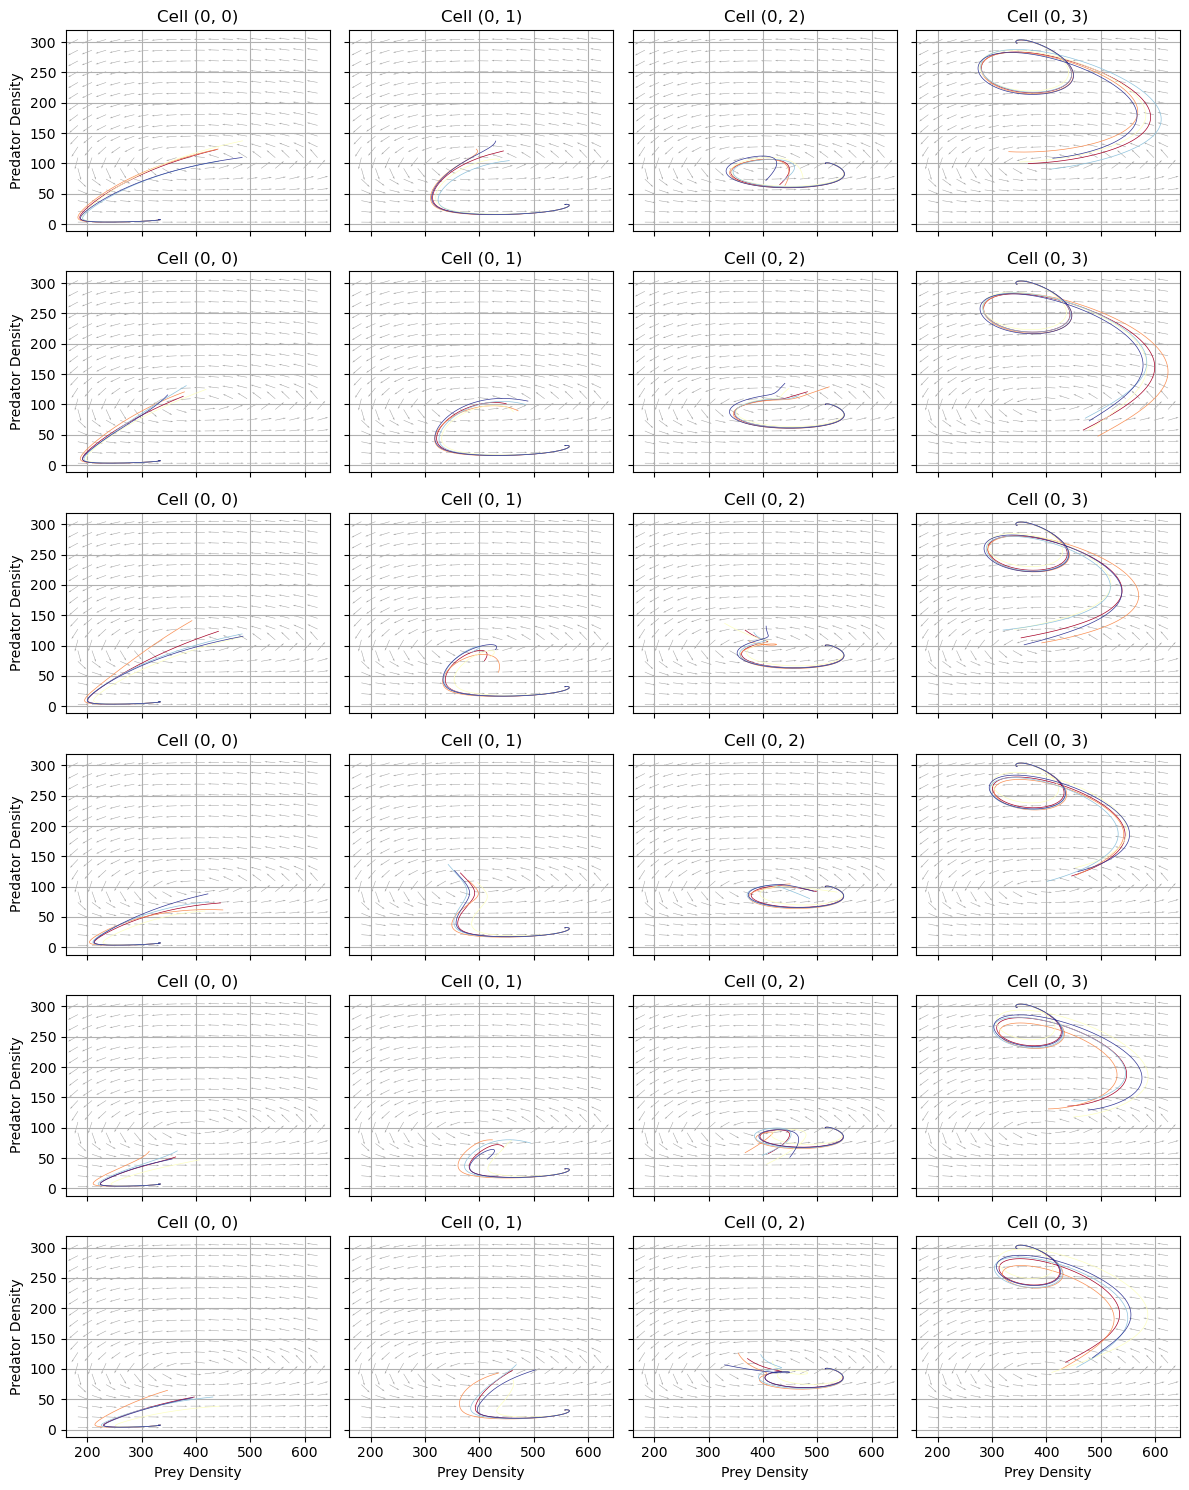

In [7]:
"""
2601547: 

The previous code only simulates for one set of starting conditions, so I again used methods from the practical to 
generate a set of phase plots with various initial starting conditions

"""

##################################################################################################################################################################################################################
#                                                                                                INPUT PARAMETERS                                                                                                #
##################################################################################################################################################################################################################

"""
2601547: 

I created a new parameter dictionary for the ensemble section as there are some items specific to it only, and I find the 
separation helps with readability for the entire process. However there are still elements from the previous block that
this section is depedant on i.e. it does not run by itself

"""

parameters_e = {
    # 2601547: Model settings:
    'n_members': 5, # 2601547: Number of distinct set of intial condition i.e. paths plotted in phase plot
    'PERT_P_e': 50, 
    'PERT_Z_e': 20, 
    # 2601547: Plot settings:
    'figsize': (12, 15),
    'x_min' : 0,
    'x_max' : 1000,
    'y_min' : 0,
    'y_max' : 400,

}

##################################################################################################################################################################################################################
#                                                                                              ENSEMBLE SIMULATION                                                                                               #
##################################################################################################################################################################################################################

def ppad_ensemble(model, grid, parameters_e, parameters):
    """
    2601547:

    This code is taken from a section of the function "pp_ensemble_ivp" (GEOGM0058: Practical 4, part 4.3) and ammended. It 
    generates arrays of some random ininital conditions for P and Z, based on the range set in the parameters
    
    """
    start_time = time.time()
    n_members, PERT_P_e, PERT_Z_e = parameters_e['n_members'], parameters_e['PERT_P_e'], parameters_e['PERT_Z_e']
    timesteps, nz, nx = parameters['timesteps'], parameters['nz'], parameters['nx']
    P_initial, Z_initial = grid['P'], grid['Z']
    # 2601547: This part of the code mainly stays the same
    #color map
    cmap = mpl.colormaps['RdYlBu'](np.linspace(0,1,n_members))
    # generate random initial conditions
    gen = lambda span: span[0] + np.random.rand(n_members) *(span[1] - span[0])
    P0_e, Z0_e = grid['P'], grid['Z']

    print(f"Initial P array:")
    print(P0_e)
    print()
    print(f"Initial Z array:")
    print(Z0_e)
    
    final_P, final_Z = np.empty(n_members), np.empty(n_members)

    # 2601547: I initialise an arry to store the simulation data
    P_e_history = []
    Z_e_history = []
    P_final = []
    Z_final = []

    PERT_P_e_rand = fixed_PERT_P_e
    PERT_Z_e_rand = fixed_PERT_Z_e 

    # 2601547: Here ammendments are made as I am using grids with my arrays
    for k, color in enumerate(cmap):  # Keep the same enumerate structure
        if k == 0:  # First simulation uses original grid
            P, Z = grid['P'], grid['Z']
        else:  # Subsequent simulations use perturbed grids
            P = grid['P'] + PERT_P_e_rand[k - 1]
            Z = grid['Z'] + PERT_Z_e_rand[k - 1]
        P_e, Z_e = np.zeros((timesteps, nz, nx)), np.zeros((timesteps, nz, nx))
        P_e[0, :, :], Z_e[0, :, :] = P, Z

        # 2601547: This runs the simulation and fills the P_e and Z_e array with the output
        for t in range(1, timesteps):
            P, Z = predator_prey_advection_diffusion_step(
                P, Z, grid['vx'], grid['Dx'], grid['Dz'], parameters, grid['dt'], grid['dx'], grid['dz']
            )
            P_e[t, :, :] = P
            Z_e[t, :, :] = Z

        # 2601547: This stores the time-series data in the array P_e_history / Z_e_history 
        P_e_history.append(P_e)
        Z_e_history.append(Z_e)

        P_final.append(P)
        Z_final.append(Z)
         
    print()
    print(f"Statistics for Final Prey Population:")
    print(f"Mean: {np.mean(P_final):,.2f}")
    print(f"Range: {np.max(np.sum(P_final, axis=(1, 2))) - np.min(np.sum(P_final, axis=(1, 2))):,.2f}")
    print(f"IQR: {np.percentile(np.sum(P_final, axis=(1, 2)), 75) - np.percentile(np.sum(P_final, axis=(1, 2)), 25):,.2f}")
    print(f"Standard Deviation: {np.std(np.sum(P_final, axis=(1, 2))):,.2f}")
    print()
    
    print(f"Statistics for Final Predator Population:")
    print(f"Mean: {np.mean(Z_final):,.2f}")
    print(f"Range: {np.max(np.sum(Z_final, axis=(1, 2))) - np.min(np.sum(Z_final, axis=(1, 2))):,.2f}")
    print(f"IQR: {np.percentile(np.sum(Z_final, axis=(1, 2)), 75) - np.percentile(np.sum(Z_final, axis=(1, 2)), 25):,.2f}")
    print(f"Standard Deviation: {np.std(np.sum(Z_final, axis=(1, 2))):,.2f}")
    print()
    
    print(f"Other Statistics:")
    end_time = time.time()
    simulation_duration = end_time - start_time
    print(f"Total simulation time: {simulation_duration:.3f} seconds")
    print()

    return np.array(P_e_history), np.array(Z_e_history)

##################################################################################################################################################################################################################
#                                                                                               PLOTTING FUNCTION                                                                                                #
##################################################################################################################################################################################################################

def plot_ppad_ensemble_with_vector_field(P_e_history, Z_e_history, parameters_e, parameters, nx, nz, grid):
    """
    Plot the ensemble trajectories with vector fields aligned to population density ranges.
    """
    n_members, figsize, x_min, x_max, y_min, y_max= parameters_e['n_members'], parameters_e['figsize'], parameters_e['x_min'], parameters_e['x_max'], parameters_e['y_min'], parameters_e['y_max']

    # Colour map for trajectories
    cmap = mpl.colormaps['RdYlBu'](np.linspace(0, 1, n_members))
    
    # Determine global range for prey and predator densities
    P_global_min, P_global_max = np.min(P_e_history), np.max(P_e_history)
    Z_global_min, Z_global_max = np.min(Z_e_history), np.max(Z_e_history)

    fig, axes = plt.subplots(nz, nx, figsize=figsize, sharex=True, sharey=True)

    for i in range(nz):
        for j in range(nx):
            ax = axes[i, j]

            # Create a grid for the vector field using global density ranges
            P_grid, Z_grid = np.meshgrid(
                np.linspace(P_global_min, P_global_max, 18),  # Increased resolution with 20 points
                np.linspace(Z_global_min, Z_global_max, 18)
            )

            # Compute the vector field
            dP_dt = parameters['alpha'] * P_grid * (1 - P_grid / parameters['K']) - parameters['beta'] * P_grid * Z_grid
            dZ_dt = parameters['delta'] * parameters['beta'] * P_grid * Z_grid - parameters['gamma'] * Z_grid

            # Normalise the vector field
            magnitude = np.sqrt(dP_dt**2 + dZ_dt**2)
            dP_dt_normalised = dP_dt / (magnitude + 1e-10)
            dZ_dt_normalised = dZ_dt / (magnitude + 1e-10)

            # Plot the vector field
            ax.quiver(
                P_grid, Z_grid, dP_dt_normalised, dZ_dt_normalised,
                color="gray", alpha=0.7, scale=0.05, scale_units='xy', width=0.002, angles='xy'
            )
            
            # Plot the trajectories for all ensemble members
            for k in range(n_members):
                P, Z = P_e_history[k, :, i, j], Z_e_history[k, :, i, j]
                ax.plot(P, Z, color=cmap[k], lw=0.5)

             #   ax.set_xlim(0, 1000)
             #   ax.set_ylim(0, 250)
            
            ax.set_title(f"Cell ({0}, {j})") # 2601547: Hardocded the rows to 0 for presentation purposes
            if i == nz - 1:
                ax.set_xlabel("Prey Density")
            if j == 0:
                ax.set_ylabel("Predator Density")
            ax.grid(True)

    plt.tight_layout()
    plt.savefig('0.00002.png', dpi=1200)
    plt.show()





##################################################################################################################################################################################################################
#                                                                                                 RUN SIMULATION                                                                                                 #
##################################################################################################################################################################################################################

nz, nx = parameters['nz'], parameters['nx']
P_e_history, Z_e_history = ppad_ensemble(predator_prey_advection_diffusion_step, grid, parameters_e, parameters)
plot_ppad_ensemble_with_vector_field(P_e_history, Z_e_history, parameters_e, parameters, nx, nz, grid)

